<a href="https://colab.research.google.com/github/NouranShaaban/workshop_geopython2019/blob/master/Kopie_von_Copy_of_Copy_of_Copy_of_SemanticSegTrial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
import tensorflow_addons as tfa
import glob
import numpy as np
from PIL import Image

In [3]:
# Set the directory where the images are stored
image_dir = '/content/IMAGES'

# Create an empty list to store the image data
image_data = []

# Use glob to get a list of all the image filenames
filenames = glob.glob(image_dir + '/*.jpg')

# Loop through the filenames and load the images
for filename in filenames:
    # Load the image and convert it to grayscale
    image = Image.open(filename).convert('L')
  
    # Resize the image to a consistent size
    image = image.resize((256, 256))
    # Convert the image to a numpy array
    image_array = np.array(image)
    
    # Append the image array to the list
    image_data.append(image_array)

# Convert the list of image arrays to a NumPy array
image_data = np.array(image_data)

# Save the image data to a file
np.save('image_data.npy', image_data)

In [4]:
image_data = image_data.reshape((-1,256,256,1))


In [5]:
# Set the directory where the images are stored
label_dir = '/content/MASKS'

# Create an empty list to store the image data
label_data = []
# Number of classes
num_classes = 4

# Use glob to get a list of all the image filenames
filenames = glob.glob(label_dir + '/*.png')

# Loop through the filenames and load the images
for filename in filenames:
    # Load the image and convert it to grayscale
    label = Image.open(filename)#.convert('L')
    
    # Resize the image to a consistent size
    label = label.resize((256, 256))
    # Convert the image to a numpy array
    label_array = np.array(label)
 
    
    # Append the image array to the list
    label_data.append(label_array)

label_data = np.array(label_data)

# Save the image data to a file
np.save('label_data.npy', label_data)

##########################################################################

In [6]:
label_data.size

1048576

In [7]:

one_hot_labels = np.zeros((len(label_data), 256, 256, num_classes))

# Iterate over the label images
for i, label_image in enumerate(label_data):
    # one-hot encode the labels
    one_hot_labels[i] = np.eye(num_classes)[label_image]

    class_names = ['Background','panel','panelWfrost','Thicknow']

# Get the index of the class with the highest probability
label_index = np.argmax(one_hot_labels, axis=-1)

# Get the name of the class
label_index = label_index.astype(int)
class_name = np.vectorize(lambda x: class_names[x])(label_index)


In [8]:
one_hot_labels.shape

(16, 256, 256, 4)

In [9]:
one_hot_labels[0,:,:,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

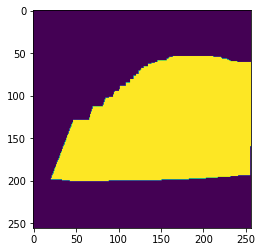

In [10]:
# Load the image data
label_data = np.load('label_data.npy')

# Number of classes
num_classes = 4

# Create an empty array to store the one-hot encoded labels
one_hot_labels = np.zeros((len(label_data), 256, 256, num_classes))

# Iterate over the label images
for i, label_image in enumerate(label_data):
    # One-hot encode the labels
    for j in range(num_classes):
        one_hot_labels[i,:,:,j] = (label_image == j)

# Get the index of the class with the highest probability
label_index = np.argmax(one_hot_labels, axis=-1)

# Get the name of the class
class_names = ['Background','panel','panelWfrost','Thicksnow']

# display the one-hot encoded image
img = label_index[1]
plt.imshow(img)
plt.show()


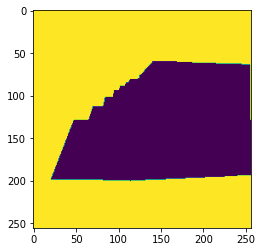

In [11]:
class_3 = np.where(label_index[4] == 0, 1,0)
class_3 = class_3.reshape((256,256))
plt.imshow(class_3)
plt.show()


In [48]:
#print(label_index[4] == 1, 0,1)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]] 0 1


In [12]:
class_counts = []
for i in range(num_classes):
    class_mask = np.where(label_index[4] == i, 1, 0)
    class_counts.append(np.sum(class_mask))

In [13]:
print(class_counts)

[39775, 25761, 0, 0]


In [14]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   # add another Conv2D layer
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x


In [15]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [16]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # add another Conv2D layer
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # add another Conv2D layer
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [18]:
 # inputs
import tensorflow.keras.layers as layers
 
inputs = layers.Input(shape=(256,256,1))

# encoder: contracting path - downsample
# 1 - downsample
f1, p1 = downsample_block(inputs, 64)
# 2 - downsample
f2, p2 = downsample_block(p1, 128)
# 3 - downsample
f3, p3 = downsample_block(p2, 256)
# 4 - downsample
f4, p4 = downsample_block(p3, 512)

# 5 - bottleneck
bottleneck = double_conv_block(p4, 1024)

# decoder: expanding path - upsample
# 6 - upsample
u6 = upsample_block(bottleneck, f4, 512)
# 7 - upsample
u7 = upsample_block(u6, f3, 256)
# 8 - upsample
u8 = upsample_block(u7, f2, 128)
# 9 - upsample
u9 = upsample_block(u8, f1, 64)

# outputs
outputs = layers.Conv2D(num_classes, 1, padding="same", activation = "softmax")(u9)

# unet model with Keras Functional API
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")


In [19]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [20]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

# x = unet_model.outputs

# # Compile the model
# unet_model = keras.Model(inputs, x)
unet_model.compile(optimizer='ADAM', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [21]:
image_data.shape

(16, 256, 256, 1)

In [22]:


from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(image_data, one_hot_labels, test_size=0.2, random_state=42)

In [23]:
train_labels.shape

(12, 256, 256, 4)

In [24]:
train_images.shape

(12, 256, 256, 1)

In [25]:
test_labels.shape


(4, 256, 256, 4)

In [27]:
test_labels.shape

(4, 256, 256, 4)

In [77]:
history = unet_model.fit(datagen.flow(train_images, train_labels, batch_size=1), epochs=10, validation_data=(test_images, test_labels))


Epoch 1/10
12/12 [==============================] - 236s 20s/step - loss: 8.7684 - accuracy: 0.5949 - val_loss: 1.7111 - val_accuracy: 0.5881
Epoch 2/10
10/12 [========================>.....] - ETA: 33s - loss: 1.3100 - accuracy: 0.5957

KeyboardInterrupt: ignored

In [78]:
unet_model.save('unet_model.h5')

In [79]:
print(predictions.shape)

(1, 256, 256, 4)


In [ ]:
unet_model.summary()

In [36]:
print(num_classes)

4


In [130]:
print(np.argmax(predictions[0], axis=-1))

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [132]:
import cv2 # Load the test image in color format
test_image = cv2.imread('test_image.jpg')

# Resize the test image to the desired size
test_image = cv2.resize(test_image, (256, 256))

# Convert the test image to grayscale
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Preprocess the test image
gray_image = gray_image.astype('float32') / 255.0

# Reshape the grayscale image to match the model input shape
gray_image = gray_image.reshape((1, 256, 256, 1))

# Make predictions on the test image
predictions = unet_model.predict(gray_image)

# Get the predicted class labels for the test image
predicted_labels = np.eye(4)[np.argmax(predictions[0], axis=-1)]



1/1 [==============================] - 5s 5s/step


In [133]:
print(predicted_labels)

[[[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 ...

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]]


In [134]:
print(predicted_labels.shape)

(256, 256, 4)


In [135]:
print(predicted_one_hot_labels.shape)

(256, 256, 4)


In [136]:
# Get the predicted class labels for the test image
predicted_labels = np.eye(4)[np.argmax(predictions[0], axis=-1)]

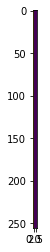

Number of pixels in class 'Background': 768
Number of pixels in class 'panel': 256
Number of pixels in class 'panelWfrost': 0
Number of pixels in class 'Thicksnow': 0


In [137]:
# Assuming you have `predicted_labels` as an array of shape (1, 256, 256, 4) containing the predicted labels
num_classes = 4

predicted_one_hot_labels = np.zeros((predicted_labels.shape[0], predicted_labels.shape[1], num_classes), dtype=np.float32)

# One-hot encode the predicted labels
for j in range(num_classes):
    predicted_one_hot_labels[:,:,j] = (predicted_labels[:,:,0] == j)


# Get the index of the class with the highest probability
predicted_label_index = np.eye(4)[np.argmax(predicted_one_hot_labels, axis=-1)]

# Get the name of the class
class_names = ['Background','panel','panelWfrost','Thicksnow']

# Display the one-hot encoded image
img = predicted_label_index[0]
plt.imshow(img)
plt.show()

# Count the number of pixels in each class
class_counts = []
for i in range(num_classes):
    class_mask = np.where(predicted_label_index[0] == i, 1, 0)
    class_counts.append(np.sum(class_mask))

# Display the class counts
for i in range(num_classes):
    print(f"Number of pixels in class '{class_names[i]}': {class_counts[i]}")


In [68]:
predicted_one_hot_labels = np.zeros((1, 256, 256, num_classes))
# One-hot encode the predicted labels
for j in range(num_classes):
    predicted_one_hot_labels[:,:,j] = (predicted_labels == j)


ValueError: ignored

In [75]:
# Assuming you have `predicted_labels` as an array of shape (1, 256, 256, 4) containing the predicted labels
num_classes = 4

# Create an empty array to store the one-hot encoded labels
predicted_one_hot_labels = np.zeros((1, 256, 256, num_classes))

# Iterate over the predicted label images
for i in range(predicted_labels.shape[0]):
    # One-hot encode the predicted labels
    for j in range(num_classes):
        predicted_one_hot_labels[i,:,:,j] = (predicted_labels[:,:,:] == j)

# Get the index of the class with the highest probability
predicted_label_index = np.argmax(predicted_one_hot_labels, axis=-1)

# Get the name of the class
class_names = ['Background','panel','panelWfrost','Thicksnow']

# Display the one-hot encoded image
img = predicted_label_index[0]
plt.imshow(img)
plt.show()

# Count the number of pixels in each class
class_counts = []
for i in range(num_classes):
    class_mask = np.where(predicted_label_index[0] == i, 1, 0)
    class_counts.append(np.sum(class_mask))

# Display the class counts
for i in range(num_classes):
    print(f"Number of pixels in class '{class_names[i]}': {class_counts[i]}")


ValueError: ignored

In [53]:
print(predicted_one_hot_labels.shape)

(1, 256, 256, 4)


In [ ]:
import cv2 
import numpy as np

# Define the color coding for each class
class_colors = [(0, 0, 0), (0, 255, 0), (0, 0, 255)]

# Load the test image and ground truth mask in color format
test_image = cv2.imread('test_image.jpg')
ground_truth_mask = cv2.imread('ground_truth_mask.png')

# Resize the test image and ground truth mask to the desired size
test_image = cv2.resize(test_image, (256, 256))
ground_truth_mask = cv2.resize(ground_truth_mask, (256, 256))

# Convert the test image and ground truth mask to grayscale
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
gray_ground_truth_mask = cv2.cvtColor(ground_truth_mask, cv2.COLOR_BGR2GRAY)

# Preprocess the test image
gray_image = gray_image.astype('float32') / 255.0

# Reshape the grayscale image to match the model input shape
gray_image = gray_image.reshape((1, 256, 256, 1))

# Make predictions on the test image
predictions = unet_model.predict(gray_image)

# Get the predicted class labels for the test image
predicted_labels = np.argmax(predictions[0], axis=-1)

# Apply color coding to the predicted image and the ground truth image
predicted_mask = np.zeros_like(test_image)
ground_truth_colored = np.zeros_like(ground_truth_mask)
for i, color in enumerate(class_colors):
    predicted_mask[predicted_labels == i] = color
    ground_truth_colored[gray_ground_truth_mask == i * 255] = color

from google.colab.patches import cv2_imshow

# Display the predicted image and the ground truth image
cv2_imshow( predicted_mask)
cv2_imshow( ground_truth_colored)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2 
import numpy as np

# Define the color coding for each class
class_colors = [(0, 0, 0), (0, 255, 0), (0, 0, 255)]

# Load the test image and ground truth mask in color format
test_image = cv2.imread('test_image.jpg')
ground_truth_mask = cv2.imread('ground_truth_mask.png')

# Convert the test image and ground truth mask to grayscale
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
gray_ground_truth_mask = cv2.cvtColor(ground_truth_mask, cv2.COLOR_BGR2GRAY)

# Resize the test image to 256x256
gray_image = cv2.resize(gray_image, (256, 256), interpolation=cv2.INTER_AREA)

# Preprocess the test image
gray_image = gray_image.astype('float32') / 255.0

# Reshape the grayscale image to match the model input shape
gray_image = gray_image.reshape((1, 256, 256, 1))

# Make predictions on the test image
predictions = unet_model.predict(gray_image)

# Get the predicted class labels for the test image
predicted_labels = np.argmax(predictions[0], axis=-1)

# Apply color coding to the predicted image and the ground truth image
predicted_mask = np.zeros_like(test_image)
ground_truth_colored = np.zeros_like(ground_truth_mask)
for i, color in enumerate(class_colors):
    predicted_mask[predicted_labels == i] = color
    ground_truth_colored[gray_ground_truth_mask == i * 255] = color

# Display the predicted image and the ground truth image
cv2.imshow('Predicted Mask', predicted_mask)
cv2.imshow('Ground Truth Mask', ground_truth_colored)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2 
import numpy as np

# Define the color coding for each class
class_colors = [(0, 0, 0), (0, 255, 0), (0, 0, 255)]

# Load the test image and ground truth mask in color format
test_image = cv2.imread('test_image.jpg')
ground_truth_mask = cv2.imread('ground_truth_mask.png')

# Convert the test image and ground truth mask to grayscale
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
gray_ground_truth_mask = cv2.cvtColor(ground_truth_mask, cv2.COLOR_BGR2GRAY)

# Preprocess the test image
gray_image = cv2.resize(gray_image, (256, 256))
gray_image = gray_image.astype('float32') / 255.0

# Reshape the grayscale image to match the model input shape
gray_image = gray_image.reshape((1, 256, 256, 1))

# Make predictions on the test image
predictions = unet_model.predict(gray_image)

# Get the predicted class labels for the test image
predicted_labels = np.argmax(predictions[0], axis=-1)

# Apply color coding to the predicted image and the ground truth image
predicted_mask = np.zeros_like(test_image)
ground_truth_colored = np.zeros_like(ground_truth_mask)
for i, color in enumerate(class_colors):
    predicted_mask[predicted_labels == i] = color
    ground_truth_colored[gray_ground_truth_mask == i * 255] = color

# Display the predicted image and the ground truth image
cv2.imshow('Predicted Mask', predicted_mask)
cv2.imshow('Ground Truth Mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2 
# Load the test image in color format
test_image = cv2.imread('test_image.jpg')

# Convert the test image to grayscale
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Preprocess the test image
gray_image = cv2.resize(gray_image, (256, 256))
gray_image = gray_image.astype('float32') / 255.0

# Reshape the grayscale image to match the model input shape
gray_image = gray_image.reshape((1, 256, 256, 1))

# Make predictions on the test image
predictions = unet_model.predict(gray_image)

# Get the predicted class labels for the test image
predicted_labels = np.argmax(predictions[0], axis=-1)

# Calculate the pixel counts for each class in the predicted labels
class_counts = []
for i in range(num_classes):
    class_mask = np.where(predicted_labels == i, 1, 0)
    class_counts.append(np.sum(class_mask))
    
# Print the pixel counts for each class
print('Pixel counts for each class:', class_counts)
print()

In [ ]:
print(class)

In [ ]:
import matplotlib.pyplot as plt

# Load the test image in color format
test_image = cv2.imread('test_image.jpg')

# Convert the test image to grayscale
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Preprocess the test image
gray_image = cv2.resize(gray_image, (256, 256))
gray_image = gray_image.astype('float32') / 255.0

# Reshape the grayscale image to match the model input shape
gray_image = gray_image.reshape((1, 256, 256, 1))

# Make predictions on the test image
predictions = unet_model.predict(gray_image)

# Get the predicted class labels for the test image
predicted_labels = np.argmax(predictions[0], axis=-1)

# Plot the test image and predicted segmentation mask
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.imshow(test_image)
ax1.set_title('Test Image')
ax2.imshow(predicted_labels, cmap='gray')
ax2.set_title('Segmentation Mask')
plt.show()


In [ ]:
# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Plot training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()